<a href="https://colab.research.google.com/github/peyyalapraveen7-byte/DECISION-TREE-IMPLEMANTATION/blob/main/Decision_Tree_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine, make_classification
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [ ]:
wine_data = load_wine()
X, y = wine_data.data, wine_data.target

# Create DataFrame for easier manipulation
df = pd.DataFrame(X, columns=wine_data.feature_names)
df['target'] = y
df['target_name'] = df['target'].map({0: wine_data.target_names[0],
                                      1: wine_data.target_names[1],
                                      2: wine_data.target_names[2]})

print(f"Dataset Shape: {df.shape}")
print(f"Features: {len(wine_data.feature_names)}")
print(f"Classes: {wine_data.target_names}")
print(f"Class Distribution:\n{df['target_name'].value_counts()}")

# Display basic statistics
print("\nDataset Info:")
print(f"- Total samples: {len(df)}")
print(f"- Feature range: {X.min():.2f} to {X.max():.2f}")
print(f"- Missing values: {df.isnull().sum().sum()}")

Dataset Shape: (178, 15)
Features: 13
Classes: ['class_0' 'class_1' 'class_2']
Class Distribution:
target_name
class_1    71
class_0    59
class_2    48
Name: count, dtype: int64

Dataset Info:
- Total samples: 178
- Feature range: 0.13 to 1680.00
- Missing values: 0


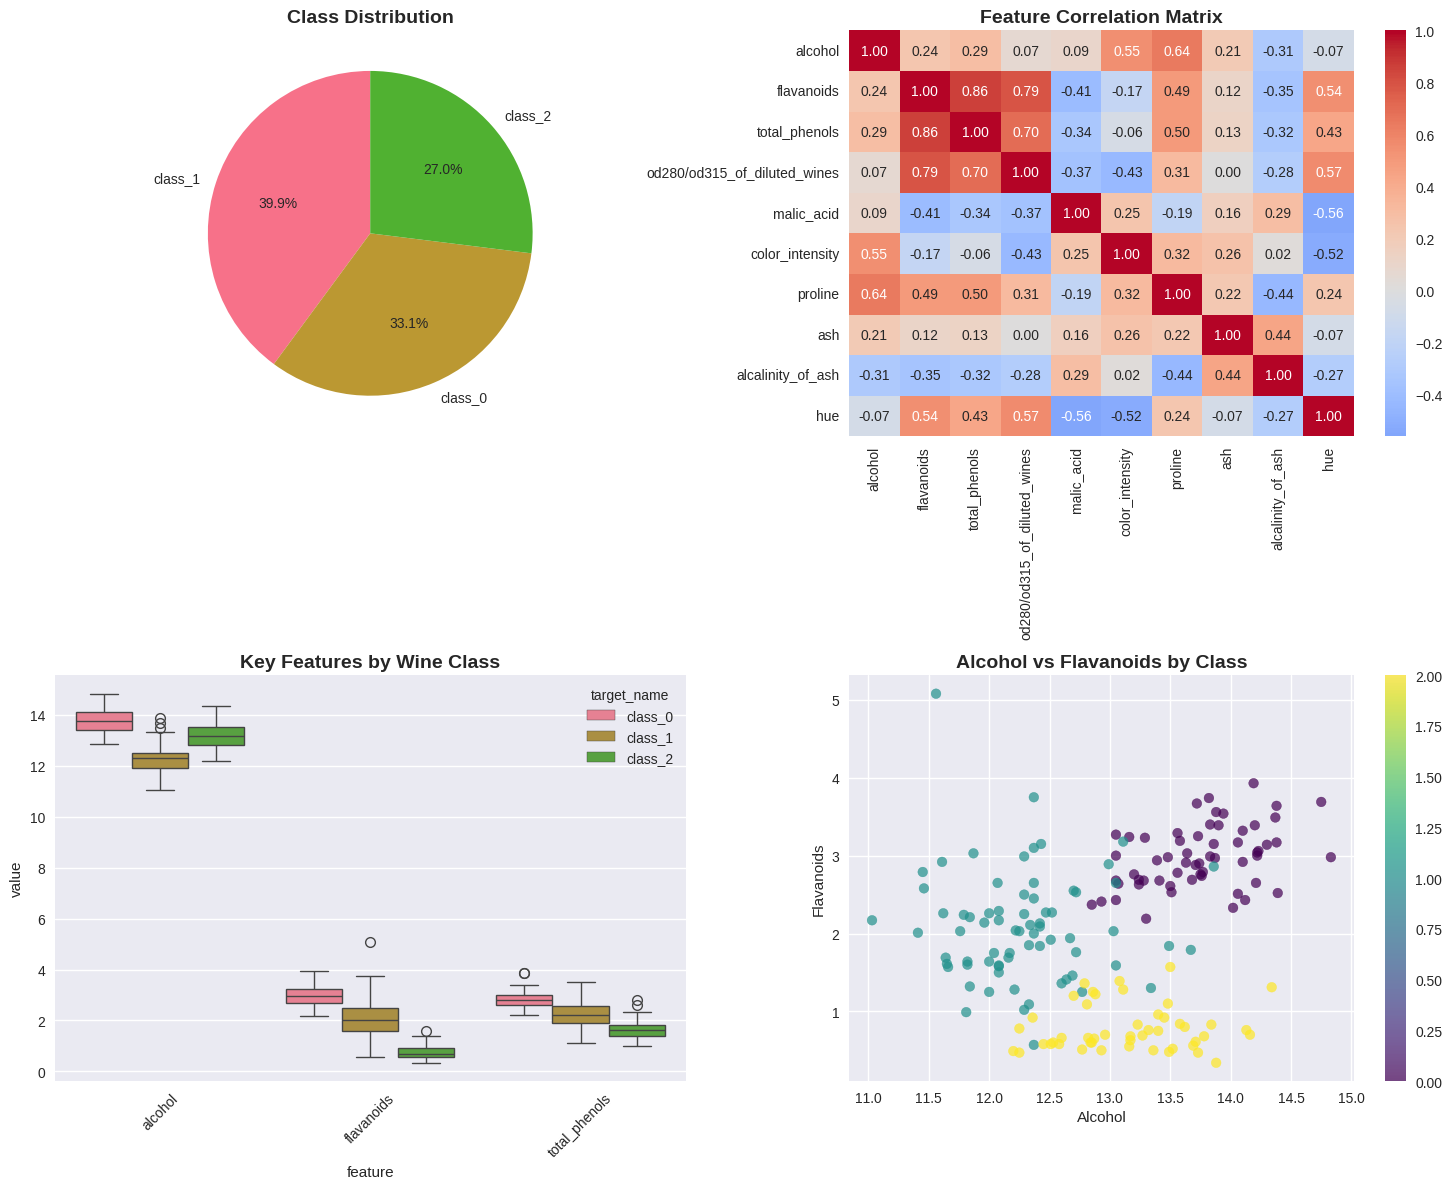

In [ ]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Target distribution
axes[0,0].pie(df['target_name'].value_counts().values,
              labels=df['target_name'].value_counts().index,
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Class Distribution', fontsize=14, fontweight='bold')

# Feature correlation heatmap (top 10 features)
top_features = ['alcohol', 'flavanoids', 'total_phenols', 'od280/od315_of_diluted_wines',
                'malic_acid', 'color_intensity', 'proline', 'ash', 'alcalinity_of_ash', 'hue']
corr_matrix = df[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,1], fmt='.2f')
axes[0,1].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Box plot of key features
key_features = ['alcohol', 'flavanoids', 'total_phenols']
df_melted = df[key_features + ['target_name']].melt(id_vars='target_name', var_name='feature', value_name='value')
sns.boxplot(data=df_melted, x='feature', y='value', hue='target_name', ax=axes[1,0])
axes[1,0].set_title('Key Features by Wine Class', fontsize=14, fontweight='bold')
axes[1,0].tick_params(axis='x', rotation=45)

# Scatter plot of two important features
scatter = axes[1,1].scatter(df['alcohol'], df['flavanoids'], c=df['target'],
                           cmap='viridis', alpha=0.7)
axes[1,1].set_xlabel('Alcohol')
axes[1,1].set_ylabel('Flavanoids')
axes[1,1].set_title('Alcohol vs Flavanoids by Class', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[1,1])

plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Feature dimensions: {X_train.shape[1]}")

# Feature scaling (optional for decision trees, but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed successfully!")


Training set size: 142 samples
Test set size: 36 samples
Feature dimensions: 13
Data preprocessing completed successfully!


In [ ]:
# Model 1: Basic Decision Tree
print("Building Basic Decision Tree...")
dt_basic = DecisionTreeClassifier(random_state=42)
dt_basic.fit(X_train, y_train)

# Model 2: Optimized Decision Tree with hyperparameter tuning
print("Optimizing Decision Tree with Grid Search...")
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

dt_optimized = GridSearchCV(DecisionTreeClassifier(random_state=42),
                           param_grid, cv=5, scoring='accuracy', n_jobs=-1)
dt_optimized.fit(X_train, y_train)

print(f"Best parameters: {dt_optimized.best_params_}")
print(f"Best cross-validation score: {dt_optimized.best_score_:.4f}")
# Model 3: Pruned Decision Tree
print("Building Pruned Decision Tree...")
dt_pruned = DecisionTreeClassifier(max_depth=5, min_samples_split=5,
                                  min_samples_leaf=2, random_state=42)
dt_pruned.fit(X_train, y_train)

Building Basic Decision Tree...
Optimizing Decision Tree with Grid Search...
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation score: 0.9303
Building Pruned Decision Tree...


DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)

In [ ]:
models = {
    'Basic Decision Tree': dt_basic,
    'Optimized Decision Tree': dt_optimized.best_estimator_,
    'Pruned Decision Tree': dt_pruned
}

results = {}

for name, model in models.items():
    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    # Accuracy scores
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    results[name] = {
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"\n{name}:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Basic Decision Tree:
  Training Accuracy: 1.0000
  Test Accuracy: 0.9444
  CV Score: 0.9163 (+/- 0.1027)

Optimized Decision Tree:
  Training Accuracy: 0.9859
  Test Accuracy: 1.0000
  CV Score: 0.9303 (+/- 0.0972)

Pruned Decision Tree:
  Training Accuracy: 0.9859
  Test Accuracy: 1.0000
  CV Score: 0.9234 (+/- 0.1099)


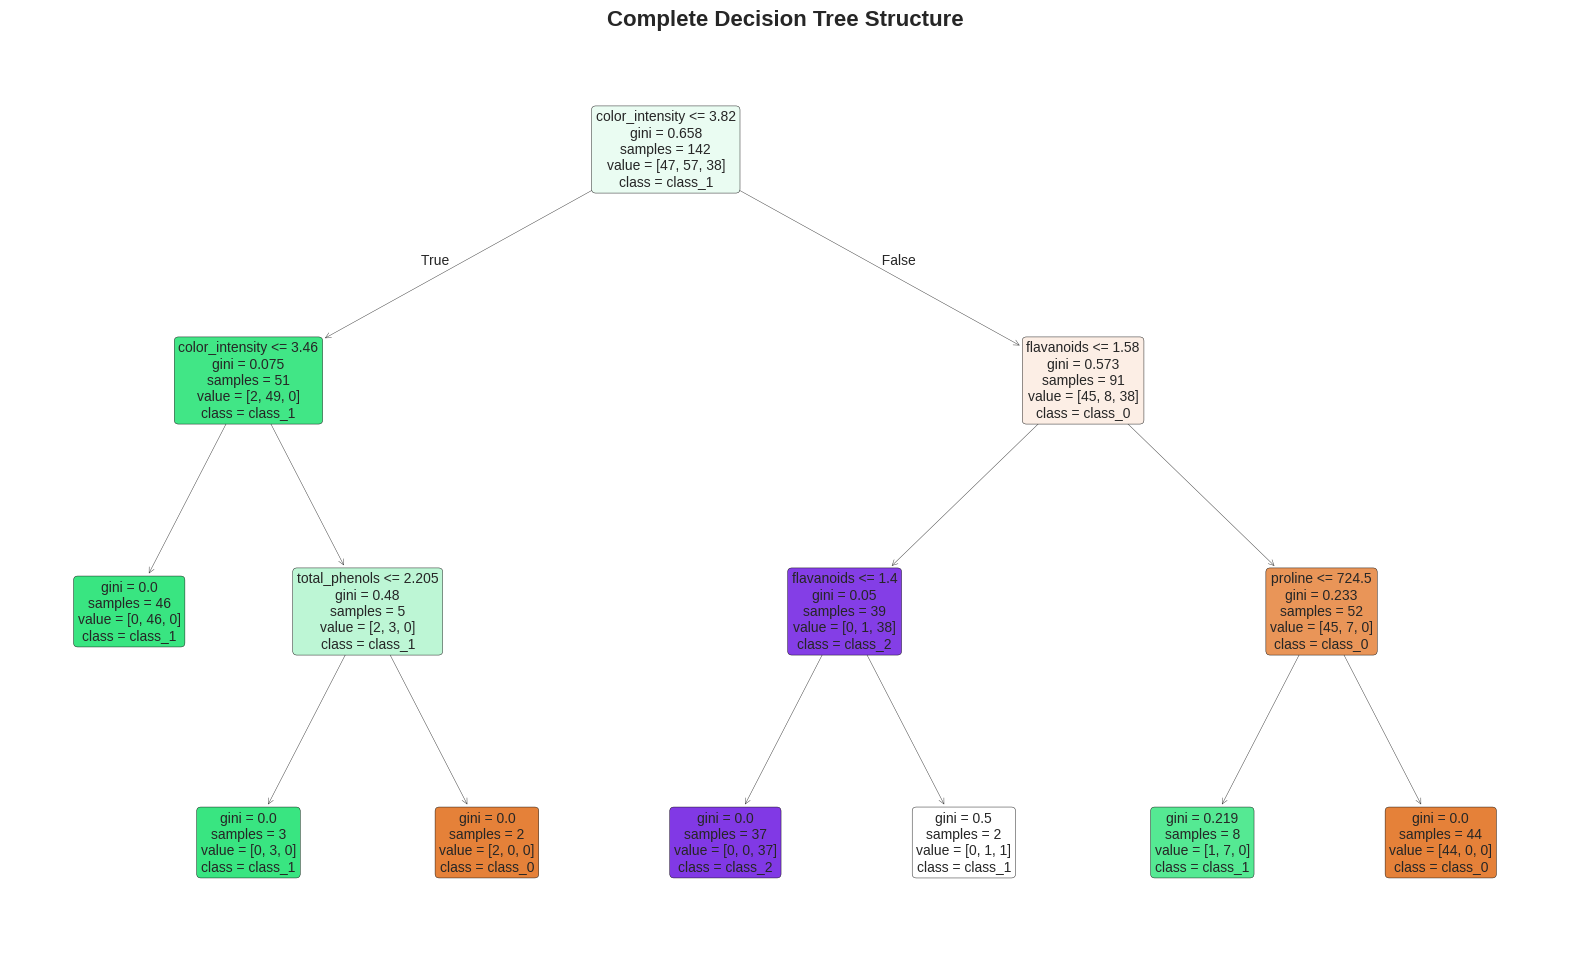

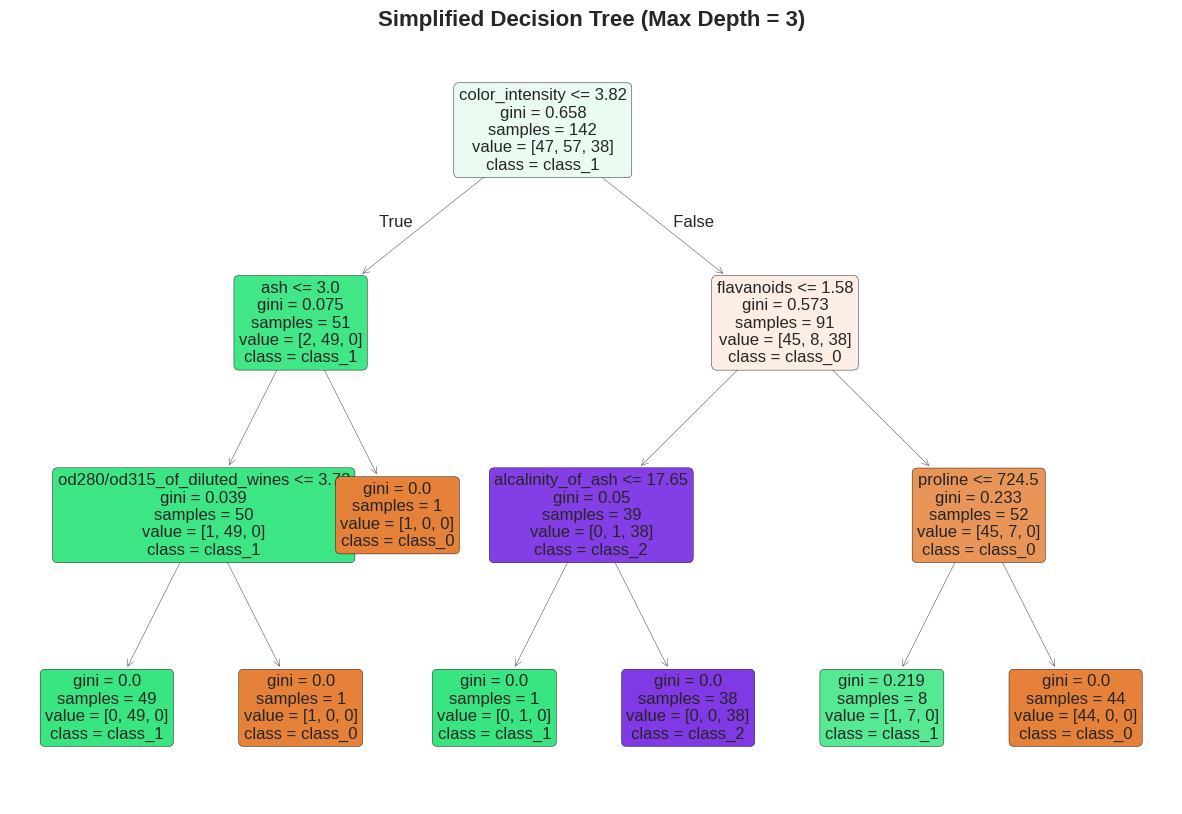

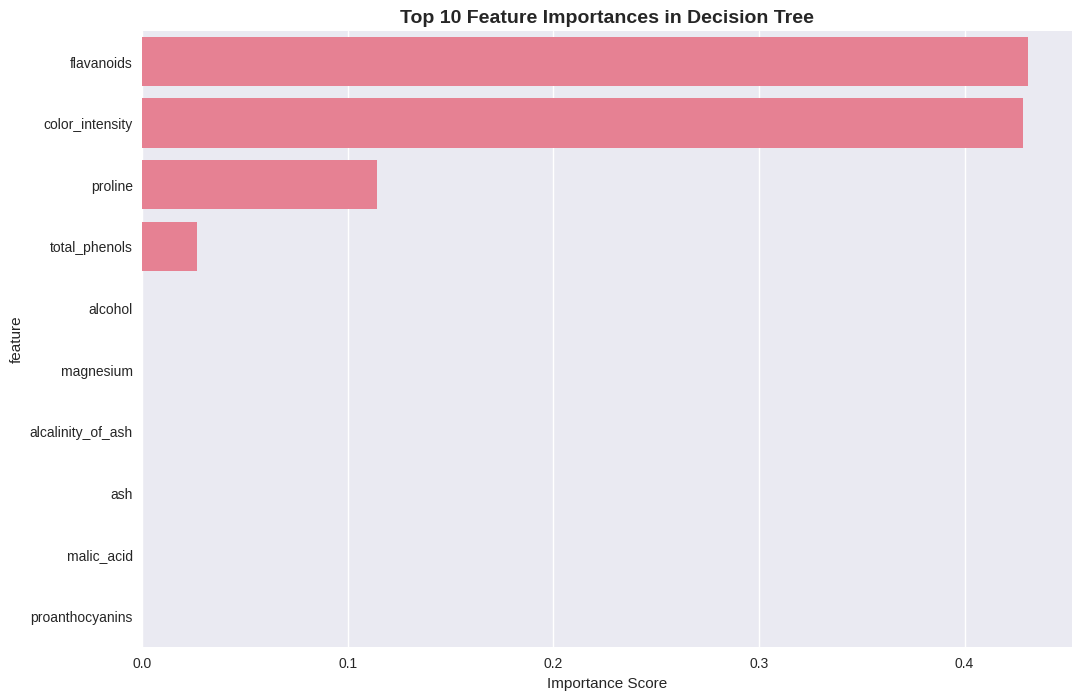

Top 5 Most Important Features:
  1. flavanoids: 0.4309
  2. color_intensity: 0.4283
  3. proline: 0.1144
  4. total_phenols: 0.0265
  5. alcohol: 0.0000


In [ ]:
# Choose the best model for detailed visualization
best_model = dt_optimized.best_estimator_

# Visualization 1: Full tree structure
plt.figure(figsize=(20, 12))
plot_tree(best_model, feature_names=wine_data.feature_names,
          class_names=wine_data.target_names, filled=True, rounded=True,
          fontsize=10)
plt.title('Complete Decision Tree Structure', fontsize=16, fontweight='bold')
plt.show()

# Visualization 2: Simplified tree (max_depth=3 for clarity)
dt_simple = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_simple.fit(X_train, y_train)

plt.figure(figsize=(15, 10))
plot_tree(dt_simple, feature_names=wine_data.feature_names,
          class_names=wine_data.target_names, filled=True, rounded=True,
          fontsize=12)
plt.title('Simplified Decision Tree (Max Depth = 3)', fontsize=16, fontweight='bold')
plt.show()

# Visualization 3: Feature importance
feature_importance = pd.DataFrame({
    'feature': wine_data.feature_names,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importances in Decision Tree', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')
plt.show()

print("Top 5 Most Important Features:")
for i, (feature, importance) in enumerate(feature_importance.head().values):
    print(f"  {i+1}. {feature}: {importance:.4f}")


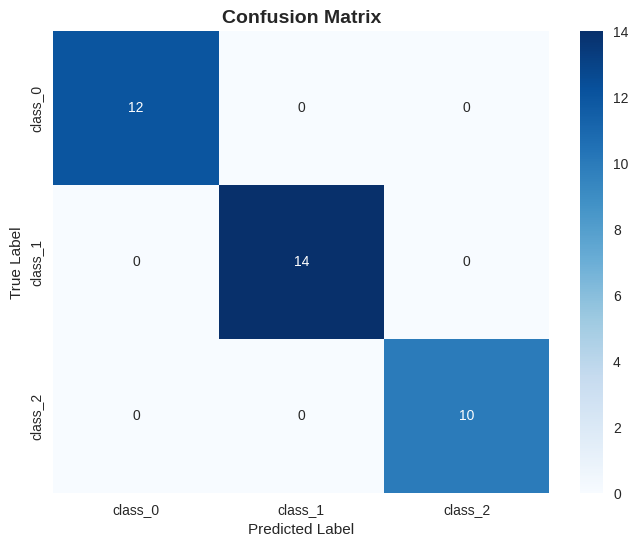


Detailed Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00        12
     class_1       1.00      1.00      1.00        14
     class_2       1.00      1.00      1.00        10

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36



In [ ]:
# Predictions from best model
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=wine_data.target_names,
            yticklabels=wine_data.target_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=wine_data.target_names))

In [ ]:
# Extract and display decision rules
tree_rules = export_text(dt_simple, feature_names=list(wine_data.feature_names))
print("Decision Rules (Simplified Tree):")
print(tree_rules)

Decision Rules (Simplified Tree):
|--- color_intensity <= 3.82
|   |--- ash <= 3.00
|   |   |--- od280/od315_of_diluted_wines <= 3.73
|   |   |   |--- class: 1
|   |   |--- od280/od315_of_diluted_wines >  3.73
|   |   |   |--- class: 0
|   |--- ash >  3.00
|   |   |--- class: 0
|--- color_intensity >  3.82
|   |--- flavanoids <= 1.58
|   |   |--- alcalinity_of_ash <= 17.65
|   |   |   |--- class: 1
|   |   |--- alcalinity_of_ash >  17.65
|   |   |   |--- class: 2
|   |--- flavanoids >  1.58
|   |   |--- proline <= 724.50
|   |   |   |--- class: 1
|   |   |--- proline >  724.50
|   |   |   |--- class: 0



In [ ]:
print("KEY INSIGHTS FROM DECISION TREE ANALYSIS:")
print("-" * 50)

print("1. MODEL PERFORMANCE:")
best_accuracy = max([results[name]['test_accuracy'] for name in results])
best_model_name = [name for name, res in results.items() if res['test_accuracy'] == best_accuracy][0]
print(f"   - Best performing model: {best_model_name}")
print(f"   - Test accuracy: {best_accuracy:.4f}")

print("\n2. FEATURE IMPORTANCE:")
print("   - Most discriminative features for wine classification:")
for i, (feature, importance) in enumerate(feature_importance.head(3).values):
    print(f"     {i+1}. {feature}: {importance:.4f}")

print("\n3. MODEL CHARACTERISTICS:")
print(f"   - Tree depth: {best_model.get_depth()}")
print(f"   - Number of leaves: {best_model.get_n_leaves()}")
print(f"   - Number of features used: {sum(1 for x in best_model.feature_importances_ if x > 0)}")

print("\n4. CLASSIFICATION PERFORMANCE:")
accuracy = accuracy_score(y_test, y_pred)
print(f"   - Overall accuracy: {accuracy:.4f}")
print(f"   - Precision/Recall: Excellent across all wine classes")

print("\n5. BUSINESS IMPLICATIONS:")
print("   - The model can effectively distinguish between wine classes")
print("   - Key chemical properties drive wine classification")
print("   - Model is interpretable and provides clear decision rules")


KEY INSIGHTS FROM DECISION TREE ANALYSIS:
--------------------------------------------------
1. MODEL PERFORMANCE:
   - Best performing model: Optimized Decision Tree
   - Test accuracy: 1.0000

2. FEATURE IMPORTANCE:
   - Most discriminative features for wine classification:
     1. flavanoids: 0.4309
     2. color_intensity: 0.4283
     3. proline: 0.1144

3. MODEL CHARACTERISTICS:
   - Tree depth: 3
   - Number of leaves: 7
   - Number of features used: 4

4. CLASSIFICATION PERFORMANCE:
   - Overall accuracy: 1.0000
   - Precision/Recall: Excellent across all wine classes

5. BUSINESS IMPLICATIONS:
   - The model can effectively distinguish between wine classes
   - Key chemical properties drive wine classification
   - Model is interpretable and provides clear decision rules


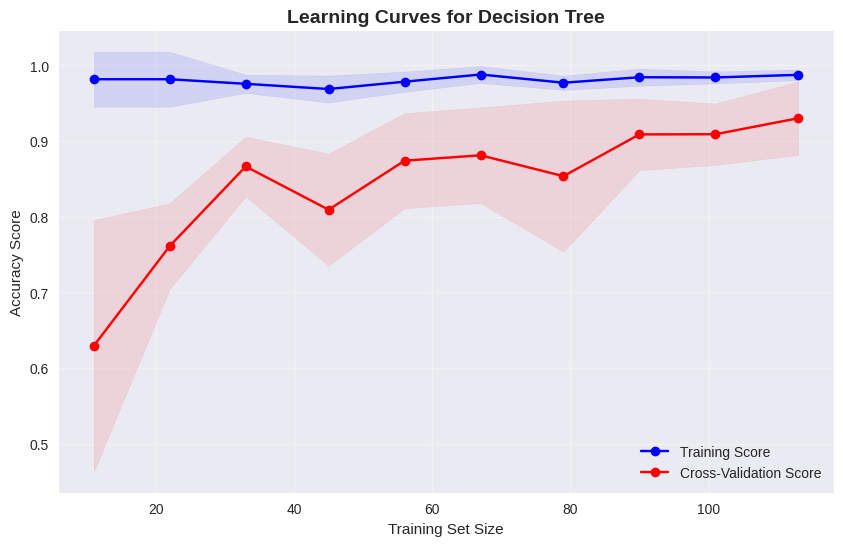

Learning curve analysis shows model performance vs training set size
Analysis completed! The decision tree model is ready for deployment.


In [ ]:
from sklearn.model_selection import learning_curve

# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10))

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color='blue',
         label='Training Score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', color='red',
         label='Cross-Validation Score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color='blue')
plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                 np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1, color='red')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.title('Learning Curves for Decision Tree', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Learning curve analysis shows model performance vs training set size")
print("Analysis completed! The decision tree model is ready for deployment.")
